In [ ]:
import numpy as np

# Ajustá esto a tu caso: tipo de datos y nombre de archivo
input_file = '../records/captura_pon_us_ch1_20250709_112308.csv'
#samples = np.fromfile(file, dtype=np.float32)  # o int8, int16, complex64, etc.

datos = np.loadtxt(f'{input_file}', delimiter=',')
samples = -datos[:, 1].astype(np.float32)

print(f"Número total de muestras: {len(datos)}")


Número total de muestras: 8000002


In [3]:
threshold = samples.max() * 0.5
bits = (samples > threshold).astype(np.uint8)

print(f"Tamaño total de samples: {len(samples)}")
print(f"Tamaño total de bits: {len(bits)}")

num_symbols = len(samples) // 32
print(f"Número total de símbolos: {num_symbols}")

Tamaño total de samples: 8000002
Tamaño total de bits: 8000002
Número total de símbolos: 250000


In [4]:
# Psync en binario: 0xB6AB31E0
psync_bits = np.array([
    1,0,1,1,0,1,1,0,
    1,0,1,0,1,0,1,1,
    0,0,1,1,0,0,0,1,
    1,1,1,0,0,0,0,0
], dtype=np.uint8)

def correlacion_binaria(bits, pattern):
    corr = np.correlate(1 - 2 * bits, 1 - 2 * pattern, mode='valid')
    return corr

corr = correlacion_binaria(bits, psync_bits)
best_idx = np.argmax(corr)

print(f"Psync encontrado en índice {best_idx} con correlación {corr[best_idx]}")

symbol_idx = best_idx // 32
print(f"Índice relativo al símbolo: {symbol_idx}")

Psync encontrado en índice 1048018 con correlación 254
Índice relativo al símbolo: 32750


In [5]:
min_sample = samples.min()
max_sample = samples.max()

print(f"Mínimo de las muestras: {min_sample}")
print(f"Máximo de las muestras: {max_sample}")

Mínimo de las muestras: -0.05880722403526306
Máximo de las muestras: 0.19999948143959045


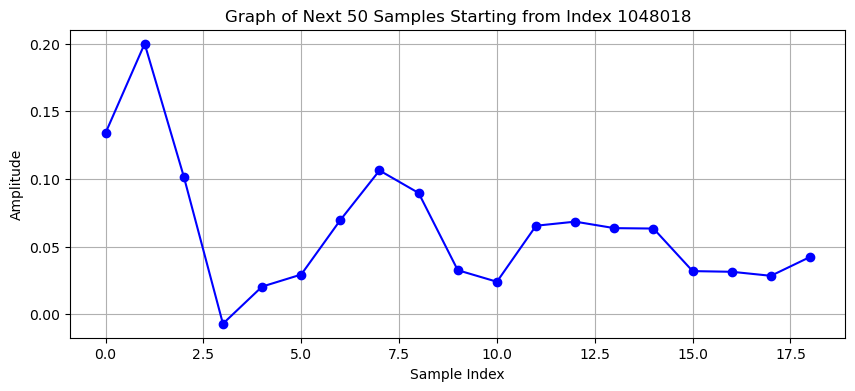

Señal filtrada aplicada con frecuencia de corte: 1250000000.0 Hz


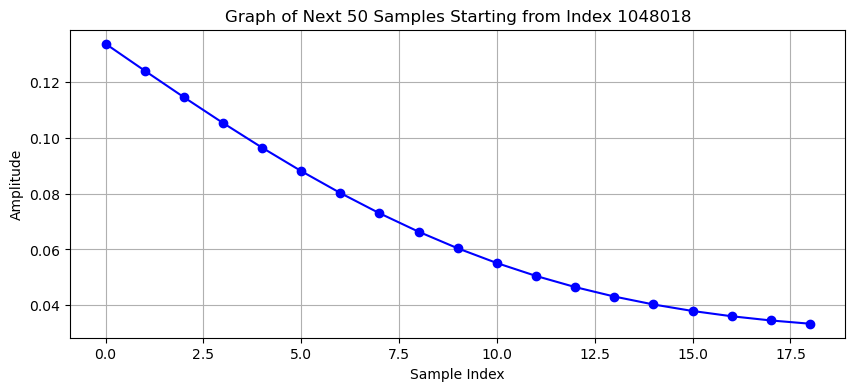

In [6]:
import matplotlib.pyplot as plt
# importar butter
from scipy.signal import butter, filtfilt

# Extract the next 50 samples starting from start_idx
samples_to_plot = samples[1048018+31:1048018+50]

# Plot the samples
plt.figure(figsize=(10, 4))
plt.plot(samples_to_plot, marker='o', linestyle='-', color='blue')
plt.title("Graph of Next 50 Samples Starting from Index 1048018")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

def low_pass_filter(data, cutoff_freq, sampling_rate):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(4, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

sampling_rate = 40e9  # Tasa de muestreo (40 Gbps)
cutoff_freq = 1.25e9  # Frecuencia de corte (1.25 GHz)

# Filtrar las muestras
filtered_samples = low_pass_filter(samples_to_plot, cutoff_freq, sampling_rate)
print(f"Señal filtrada aplicada con frecuencia de corte: {cutoff_freq} Hz")

# Plot the samples
plt.figure(figsize=(10, 4))
plt.plot(filtered_samples, marker='o', linestyle='-', color='blue')
plt.title("Graph of Next 50 Samples Starting from Index 1048018")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [58]:
4725937+31

4725968

In [8]:
975/31250

0.0312

Número de símbolos a graficar: 559


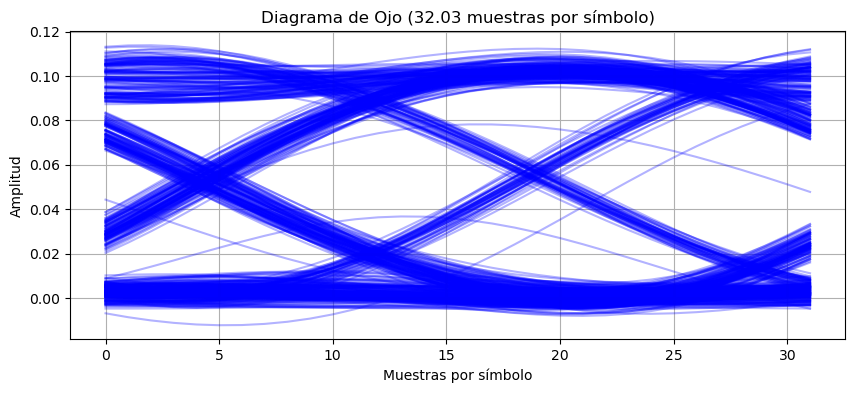

In [26]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import resample_poly

import matplotlib.pyplot as plt
# Parámetros
start_idx = 1048018 + 32*128
samples_per_symbol = 32
num_symbols_to_plot = int(18000 // samples_per_symbol)  # Asegurar que sea un número entero

# Extraer las muestras necesarias
end_idx = int(start_idx + num_symbols_to_plot * samples_per_symbol)  # Convertir a entero

subset_samples = samples[start_idx:end_idx]

# Filtrar las muestras
cutoff_freq = 1.25e9  # Frecuencia de corte (1.25 GHz)
sampling_rate = 40e9  # Tasa de muestreo (40 Gbps)
filtered_subset_samples = low_pass_filter(subset_samples, cutoff_freq, sampling_rate)

# resampleo
up = 972*32
down = 31250
resampled = resample_poly(filtered_subset_samples, up, down)

num_symbols_to_plot = int(len(resampled) // samples_per_symbol)  # Asegurar que sea un número entero
print(f"Número de símbolos a graficar: {num_symbols_to_plot}")

# Crear el diagrama de ojo
eye_diagram = np.zeros((num_symbols_to_plot, int(np.ceil(samples_per_symbol))))  # Ajustar tamaño

for i in range(num_symbols_to_plot):
    start = int(i * samples_per_symbol)
    end = start + samples_per_symbol
    if end > len(resampled):
        break
    trace = resampled[start:end]
    
    # Interpolación para ajustar a un número entero de muestras por símbolo
    x_original = np.linspace(0, 1, len(trace))
    x_target = np.linspace(0, 1, int(np.ceil(samples_per_symbol)))  # Redondear hacia arriba
    interpolator = interp1d(x_original, trace, kind='linear', fill_value="extrapolate")
    eye_diagram[i, :] = interpolator(x_target)

# Mostrar el diagrama de ojo
plt.figure(figsize=(10, 4))
for trace in eye_diagram:
    plt.plot(trace, color='blue', alpha=0.3)
plt.title("Diagrama de Ojo (32.03 muestras por símbolo)")
plt.xlabel("Muestras por símbolo")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()

In [29]:

samples_per_symbol = 32
optimal_sample_position = 13 # Posición de la muestra con el ojo más abierto
num_symbols_to_plot = len(filtered_subset_samples) // samples_per_symbol

threshold = 0.05

decoded_bits = []
for i in range(num_symbols_to_plot):
    sample_idx = i * samples_per_symbol + (optimal_sample_position - 1)
    sample_value = filtered_subset_samples[sample_idx]
    decoded_bits.append(1 if sample_value > threshold else 0)

decoded_bits = np.array(decoded_bits, dtype=np.uint8)
print(f"Bits decodificados: {decoded_bits}")

Bits decodificados: [0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1
 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1 0 0 0 0 0 1 1 1 1
 0 0 1 1 0 1 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 0
 0 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 0 0 0 0 1 0 0 0 1 0 0 1 1
 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1
 1 1 0 1 1 0 0 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1
 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0
 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 1 1 1 0 0 1 1
 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1
 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0
 1 0 

In [ ]:
40/1.2488
[0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1
 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0 1 1 1 0 0 0 0 0 1 1 1 1 0
 0 1 1 0 1 1 1 1 1 1 0 0 1 0 1 0 0 0 0]


[1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 0 0
 1 1 0 1 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1]

    1,0,1,1,0,1,1,0,
    1,0,1,0,1,0,1,1,
    0,0,1,1,0,0,0,1,
    1,1,1,0,0,0,0,0

32.03074951953876

In [ ]:
# En decoded_bits detectar el patrón Plim 1 0 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 1 0 

# Encontrar el patrón Plim en decoded_bits
plim_pattern = np.array([1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0], dtype=np.uint8)    
def find_pattern_in_bits(bits, pattern):
    pattern_len = len(pattern)
    matches = []

    for i in range(len(bits) - pattern_len + 1):
        if np.array_equal(bits[i:i + pattern_len], pattern):
            matches.append(i)

    return matches

pattern_indices = find_pattern_in_bits(decoded_bits, plim_pattern)

# Mostrar los índices del patrón Plim
if len(pattern_indices) > 0:
    print(f"Patrón Plim encontrado en índices: {pattern_indices}")
else:
    print("Patrón Plim no encontrado en los bits decodificados.")
# Mostrar los bits decodificados
print(f"Bits decodificados: {decoded_bits}")


Patrón Plz.im encontrado en índices: [9]
Bits decodificados: [0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1
 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1 0 0 0 0 0 1 1 1 1
 0 0 1 1 0 1 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 1 1 0 1 1 0 1 1 1 0 0 0 1 1 0
 0 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 0 0 0 0 1 0 0 0 1 0 0 1 1
 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1
 1 1 0 1 1 0 0 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 1
 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0
 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 1 1 1 0 0 1 1
 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1
 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [33]:
decoded_bits[9:20]

array([1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0], dtype=uint8)